In [1]:
# Import libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import cudf
import numpy as np


ModuleNotFoundError: No module named 'cudf'

In [2]:
!pip install cudf

  Using cached cudf-0.6.1.post1.tar.gz (1.1 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for cudf
Failed to build cudf
  Running setup.py install for cudf: started
  Running setup.py install for cudf: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [34 lines of output]
  running bdist_wheel
  running build
  C:\ProgramData\Anaconda3\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
    warnings.warn(
  installing to build\bdist.win-amd64\wheel
  running install
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Junaid\AppData\Local\Temp\pip-install-963ma9yz\cudf_8bbcd86bde0744a8ba902f8f1b98d6d4\setup.py", line 18, in <module>
      setup(name=pkg,
    File "C:\ProgramData\Anaconda3\lib\site-packages\setuptools\__init__.py", line 87, in setup
      return distutils.core.setup(**attrs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\setuptools\_distutils\core.py", line 185, in setup
      return ru

In [2]:
df1=cudf.read_parquet('/home/junaid_id/Merlin/output.parquet')

In [3]:
df = df1.to_pandas()

int64
int64
int64
int64
int64


In [4]:
### import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

# Preprocess the data to create input sequences and target labels
sequences = []
targets = []
for index, row in df.iterrows():
    city_id_list = row['city_id-list'].tolist()
    sequences.append(city_id_list[:-1])
    targets.append(city_id_list[-1])

    
max_sequence_length = 4
print(max_sequence_length)
# Pad the sequences with a padding token
padding_token = 0


df['city_id-list'] = [sequence + [padding_token] * (max_sequence_length - (len(sequence))) for sequence in sequences]
df['target_city'] = targets

/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4


4


In [5]:
df

,duration_norm,utrip_id,city_id-list,checkin-first,checkout-last,booker_country-first,hotel_country-list,city_id-count,duration,target_city
0,-0.812113,2,"[2341, 1824, 1560, 3075]",2016-09-08,2016-09-13,2,"[5, 5, 5, 5, 1]",5,5.0,2
1,2.003619,3,"[5142, 997, 1732, 1732]",2016-04-12,2016-04-28,2,"[2, 2, 2, 2, 2]",5,16.0,1732
2,-0.044186,4,"[275, 234, 31, 43]",2016-08-17,2016-08-25,5,"[40, 40, 16, 16, 16]",5,8.0,121
3,-0.556137,5,"[8058, 3898, 1313, 51]",2016-04-21,2016-04-27,3,"[57, 57, 57, 8, 1]",5,6.0,2
4,-0.556137,6,"[3653, 8094, 499, 1191]",2016-07-31,2016-08-06,3,"[9, 9, 9, 9, 9]",5,6.0,2872
...,...,...,...,...,...,...,...,...,...,...
9797,-0.556137,9799,"[15, 0, 0, 0]",2016-04-25,2016-05-01,3,"[13, 13]",2,6.0,3088
9798,-1.324064,9800,"[1271, 0, 0, 0]",2016-06-06,2016-06-09,4,"[27, 27]",2,3.0,309
9799,-1.580039,9801,"[98, 0, 0, 0]",2016-04-25,2016-04-27,3,"[3, 3]",2,2.0,7
9800,-1.324064,9802,"[7266, 0, 0, 0]",2016-07-20,2016-07-23,4,"[8, 8]",2,3.0,619


In [6]:
# Shuffle data
df = df.sample(frac=1).reset_index(drop=True)

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
X_train, X_test = df["city_id-list"][:train_size], df["city_id-list"][train_size:]
y_train, y_test = df["target_city"][:train_size], df["target_city"][train_size:]


In [7]:
# Convert X_train and X_test to numpy arrays
X_train = np.array([np.array(l, dtype=int) for l in X_train])
X_test = np.array([np.array(l, dtype=int) for l in X_test])

In [8]:
X_test

array([[ 944,  944,  944,  944],
       [5439,  288,   40, 3673],
       [7527, 6022,  310,  973],
       ...,
       [ 712,  712, 3925,    0],
       [  24,  316,  343,    0],
       [ 450,  450,  450,  450]])

In [9]:
# Import itertools library
import itertools

In [28]:
# Flatten city_id-list column and find unique values
unique_city_ids = list(set(itertools.chain.from_iterable(df["city_id-list"])))


# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(unique_city_ids), output_dim=32, mask_zero=True))
model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
model.add(tf.keras.layers.LSTM(units=128))
model.add(tf.keras.layers.Dense(units=8, activation="relu"))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)


# Define learning rate schedule
def lr_schedule(epoch):
    if epoch < 30:
        return 0.00001
    #elif epoch < 30:
        #return 0.00001
    else:
        return 0.000001

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


# Compile model
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])


In [87]:
unique_city_ids[-5:]

[8365, 8366, 8367, 8368, 8369]

In [29]:
# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[lr_scheduler])


Epoch 1/50
246/246 [==============================] - 12s 25ms/step - loss: 6066.1338 - accuracy: 0.0497 - val_loss: 5727.8325 - val_accuracy: 0.0729 - lr: 1.0000e-05
Epoch 2/50
246/246 [==============================] - 4s 15ms/step - loss: 5107.4614 - accuracy: 0.0899 - val_loss: 5267.7446 - val_accuracy: 0.0969 - lr: 1.0000e-05
Epoch 3/50
246/246 [==============================] - 4s 15ms/step - loss: 4753.7656 - accuracy: 0.1110 - val_loss: 4949.7798 - val_accuracy: 0.1061 - lr: 1.0000e-05
Epoch 4/50
246/246 [==============================] - 4s 15ms/step - loss: 4487.6963 - accuracy: 0.1177 - val_loss: 4690.5942 - val_accuracy: 0.1117 - lr: 1.0000e-05
Epoch 5/50
246/246 [==============================] - 4s 15ms/step - loss: 4263.1655 - accuracy: 0.1153 - val_loss: 4462.9360 - val_accuracy: 0.1056 - lr: 1.0000e-05
Epoch 6/50
246/246 [==============================] - 4s 15ms/step - loss: 4060.0562 - accuracy: 0.1066 - val_loss: 4251.3501 - val_accuracy: 0.0979 - lr: 1.0000e-05
Epo

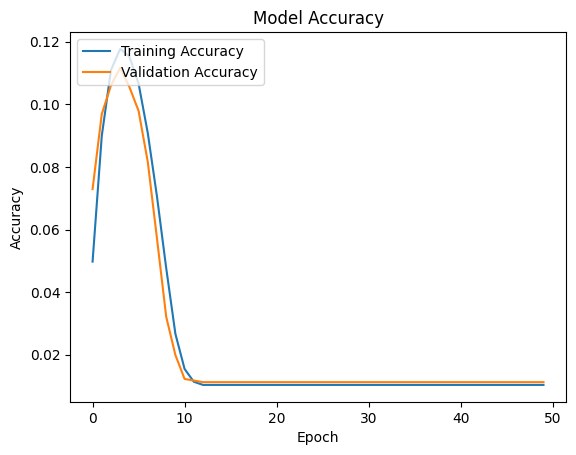

In [30]:
# Import matplotlib
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"], loc="upper left")
plt.show()

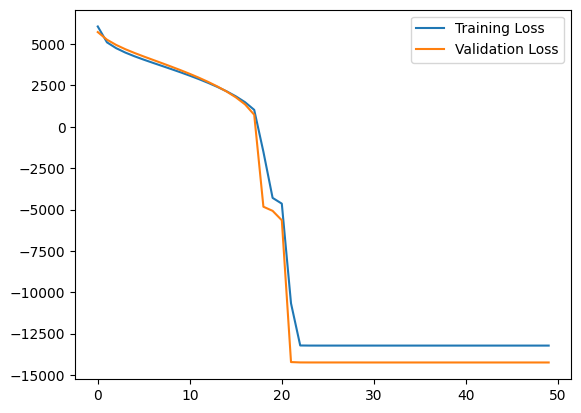

In [31]:
# Get the training and validation loss values
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

# Plot the training and validation loss
plt.plot(train_loss, label="Training Loss")
plt.plot(valid_loss, label="Validation Loss")
plt.legend()
plt.show()


In [46]:
def accuracy_at_k(model, X, y, k):
    # Predict top k items
    y_pred = model.predict(X).argsort(axis=1)[:, -k:]
    y=y.to_numpy()
    # Calculate accuracy
    accuracy = 0
    for i in range(len(y_pred)):
        if y[i] in y_pred[i]:
            accuracy += 1
    accuracy /= len(y_pred)

    return accuracy


In [33]:
# Make predictions for the input data using the model
predictions = model.predict(X_train)

# Find the top 4 predictions for each row
top_predictions = np.argpartition(-predictions, 4, axis=1)[:, :4]

246/246 [==============================] - 3s 5ms/step


In [50]:
y_pred = model.predict(X_test).argsort(axis=1)[:, -4:]

62/62 [==============================] - 0s 5ms/step


In [47]:
accat4 = accuracy_at_k(model, X_test, y_test, 4)

62/62 [==============================] - 0s 5ms/step


In [53]:
y_pred[0]

array([7, 2, 5, 4])

In [48]:
accat4

0.26925038245792965

0.27764315776048976

In [86]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

In [57]:
# Define model2 using GRU
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(input_dim=len(unique_city_ids), output_dim=32, mask_zero=True))
model1.add(tf.keras.layers.GRU(units=128, return_sequences=True))
model1.add(tf.keras.layers.GRU(units=128, return_sequences=True))
model1.add(tf.keras.layers.GRU(units=128))
model1.add(tf.keras.layers.Dense(units=8, activation="relu"))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)


# Define learning rate schedule
def lr_schedule(epoch):
    if epoch < 30:
        return 0.00001
    #elif epoch < 30:
        #return 0.00001
    else:
        return 0.000001

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


# Compile model
model1.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])


In [79]:
# Train model
history = model1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[lr_scheduler])

Epoch 1/50


ValueError: in user code:

    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 8) are incompatible


In [74]:
y_pred1 = model1.predict(X_test).argsort(axis=1)[:, -4:]

62/62 [==============================] - 3s 5ms/step


In [75]:
accat41 = accuracy_at_k(model1, X_test, y_test, 4)

62/62 [==============================] - 0s 5ms/step


In [73]:
accat41

0.0

In [78]:
# Define model1 using GRU
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(input_dim=len(unique_city_ids), output_dim=32, mask_zero=True))
model1.add(tf.keras.layers.GRU(units=128, return_sequences=True))
model1.add(tf.keras.layers.GRU(units=128, return_sequences=True))
model1.add(tf.keras.layers.GRU(units=128))
model1.add(tf.keras.layers.Dense(units=8, activation="softmax"))

# Set the output of the model to be the output of the final layer
model1 = tf.keras.Model(inputs=model1.inputs, outputs=model1.layers[-1].output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile model
model1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


In [88]:
# Convert y_train and y_test to one-hot encoded targets
num_cities = 8369
y_train_one_hot = tf.keras.utils.to_categorical(y_train.to_numpy(), num_classes=num_cities)
y_test_one_hot = tf.keras.utils.to_categorical(y_test.to_numpy(), num_classes=num_cities)

# Train model
history = model1.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, validation_data=(X_test, y_test_one_hot), callbacks=[lr_scheduler])


Epoch 1/50


ValueError: in user code:

    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/junaid_id/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/keras/backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 8369) and (None, 8) are incompatible


In [69]:
top_predictions

array([[  90,  138, 7265, 3126],
       [5763, 5439, 6451,  245],
       [4532, 6135, 1500, 5290],
       ...,
       [7408, 1030, 3190, 2852],
       [4889, 1530, 4614,  256],
       [6460, 1663, 2183,   39]])

In [76]:
# Make predictions for the input data
predictions = model1.predict(X_test)

# The predictions array will have shape (num_samples, num_cities)
# Each row represents the probabilities for each city for a given sample
print(predictions.shape)

# Select the top 4 predictions for each row
top_predictions = np.argpartition(-predictions, 4, axis=1)[:, :4]

# Get the probabilities of the top predictions
top_probabilities = np.zeros((len(predictions), 4))
for i in range(len(predictions)):
    top_probabilities[i] = predictions[i, top_predictions[i]]


62/62 [==============================] - 0s 5ms/step
(1961, 7504)


In [77]:
predictions

array([[0.00013333, 0.00013317, 0.00013328, ..., 0.00013327, 0.00013307,
        0.00013323],
       [0.00013338, 0.00013326, 0.00013338, ..., 0.00013307, 0.00013333,
        0.00013326],
       [0.00013326, 0.00013326, 0.00013326, ..., 0.00013319, 0.0001332 ,
        0.00013324],
       ...,
       [0.00013338, 0.00013323, 0.00013332, ..., 0.00013325, 0.00013324,
        0.00013321],
       [0.0001332 , 0.00013323, 0.00013325, ..., 0.00013303, 0.00013318,
        0.00013315],
       [0.0001333 , 0.00013316, 0.00013332, ..., 0.00013306, 0.00013316,
        0.00013331]], dtype=float32)

In [120]:
# Preprocess data
#X_train, X_test, y_train, y_test = train_test_split(df[["city_id-list","duration_norm", "city_id-count"]], df["target_city"], test_size=0.2)


# Split data into training and testing sets
train_size = int(len(df) * 0.8)
X_train, X_test = df[["city_id-list","duration_norm", "city_id-count"]][:train_size], df[["city_id-list","duration_norm", "city_id-count"]][train_size:]
y_train, y_test = df["target_city"][:train_size], df["target_city"][train_size:]



In [129]:
cols_as_np = np.concatenate(np.array([np.array(l, dtype=int) for l in X_train['city_id-list']]),X_train['duration_norm'].values)

TypeError: only integer scalar arrays can be converted to a scalar index

In [130]:
X_train['duration_norm'].values

array([-0.81211268, -1.06808826, -0.30016153, ...,  0.21178963,
       -0.81211268, -0.30016153])

In [118]:
# Convert X_train and X_test to numpy arrays
X_train['city_id-list'] = np.array([np.array(l, dtype=int) for l in X_train['city_id-list']])
X_test['city_id-list'] = np.array([np.array(l, dtype=int) for l in X_test['city_id-list']])

In [111]:
# Convert X_train and X_test to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Define model
input1 = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(32, activation="relu")(input1)
input2 = tf.keras.Input(shape=(5,))
y = tf.keras.layers.Embedding(input_dim=len(unique_city_ids), output_dim=32)(input2)
y = tf.keras.layers.LSTM(units=32)(y)
z = tf.keras.layers.concatenate([x, y])
output = tf.keras.layers.Dense(1, activation="sigmoid")(z)
model = tf.keras.Model(inputs=[input1, input2], outputs=output)

# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [109]:
X_train

,city_id-list,duration_norm,city_id-count
10,"[48, 141, 456, 0]",-0.556137,4
8137,"[583, 271, 89, 0]",-0.556137,4
1066,"[3596, 3596, 91, 0]",-0.300162,4
7491,"[372, 437, 781, 0]",-0.812113,4
5210,"[11, 2907, 6979, 4412]",-0.812113,5
...,...,...,...
8108,"[911, 251, 254, 65]",-0.044186,5
1990,"[14, 155, 8, 0]",-1.068088,4
834,"[6454, 7, 60, 0]",0.979716,4
4094,"[48, 58, 41, 0]",0.211790,4


In [112]:
# Train model
history = model.fit([X_train, y_train], y_train, epochs=10, batch_size=32, validation_data=([X_test, y_test], y_test))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).